### **MDS7104: Aprendizaje de Máquinas**

**Magíster en Ciencia de Datos Universidad de Chile**

**Profesor:** Felipe Tobar

**Ayuxiliares:** Catherine Benavides, Camila Bergasa, Víctor Caro, Camilo Carvajal Reyes, Diego Cortez M., Stefano Schiappacasse

# Modelos de función de base adaptativa

Este notebook es una pequeña demostración del uso de modelos de árboles, boosting, bosques aleatorios y boosting. Fue desarrollado por Camilo Carvajal Reyes tomando muchos elementos del Auxiliar 7 2023 desarrollado por Diego Cortés. En particular este notebook genera las figuras del apunte para la unidad **Modelos de función de base adaptativa**.

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)


Motivación: árboles de regresión.

In [2]:
def samplear_gaussianas(N,mu=0,sd=7.5):
    # retorna un vector de tamaño N con realizaciones de una v.a. Gaussiana
    return np.random.normal(loc=mu,scale=sd,size=N)

In [3]:
data = np.loadtxt('../datos/gauss2.csv')
X = data[:, 1]
eps = samplear_gaussianas(X.shape[0])
y = data[:, 0] + eps

In [4]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

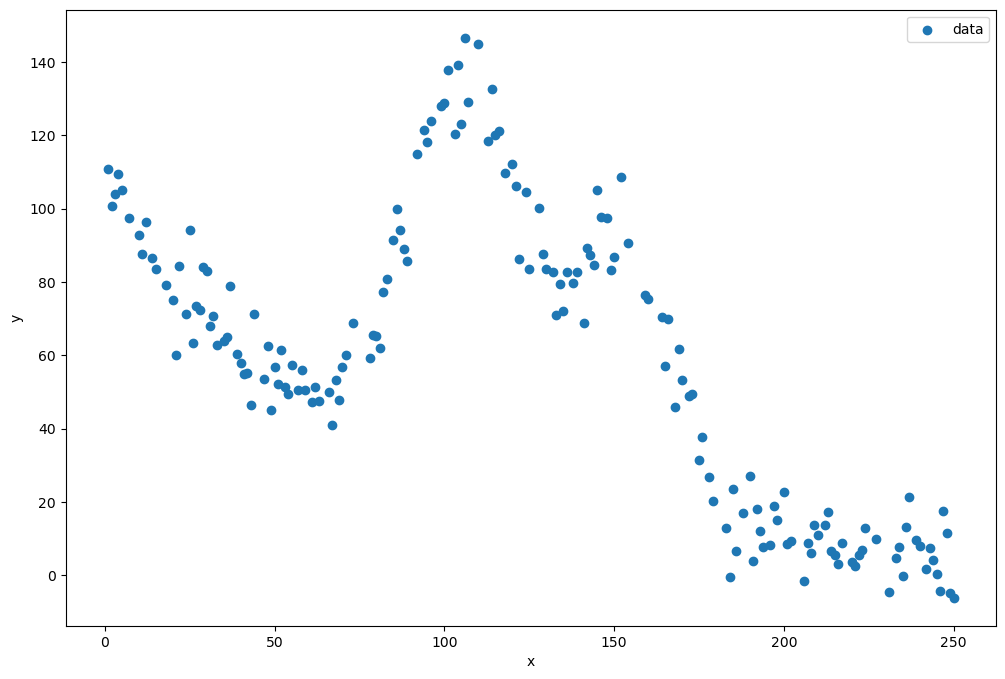

In [5]:
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(X,y,label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.plot();

In [6]:
print("Dataset size = {}".format(X.shape[0]))

Dataset size = 175


Usando los datos, ajustaremos dos árboles. Uno corresponde a un árbol sin límite de profundidad (que por ende terminará sobre-ajustado) y uno con profundidad 4 (que parece ser una mejor aproximación de la función, por inspección).

In [7]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)
regr_2 = DecisionTreeRegressor()
regr_1.fit(X.reshape(-1, 1), y.reshape(-1, 1))
regr_2.fit(X.reshape(-1, 1), y.reshape(-1, 1))

DecisionTreeRegressor()

In [8]:
X_test = np.arange(0.0, 250.0, 1)
y_1 = regr_1.predict(X_test.reshape(-1, 1))
y_2 = regr_2.predict(X_test.reshape(-1, 1))

Primeramente plotearemos un árbol de profundidad "cero". Esto corresponde a asignar la media de todo el conjunto como predicción. Acá el nodo del árbol representa la partición trivial: el único subconjunto es todo el conjunto.

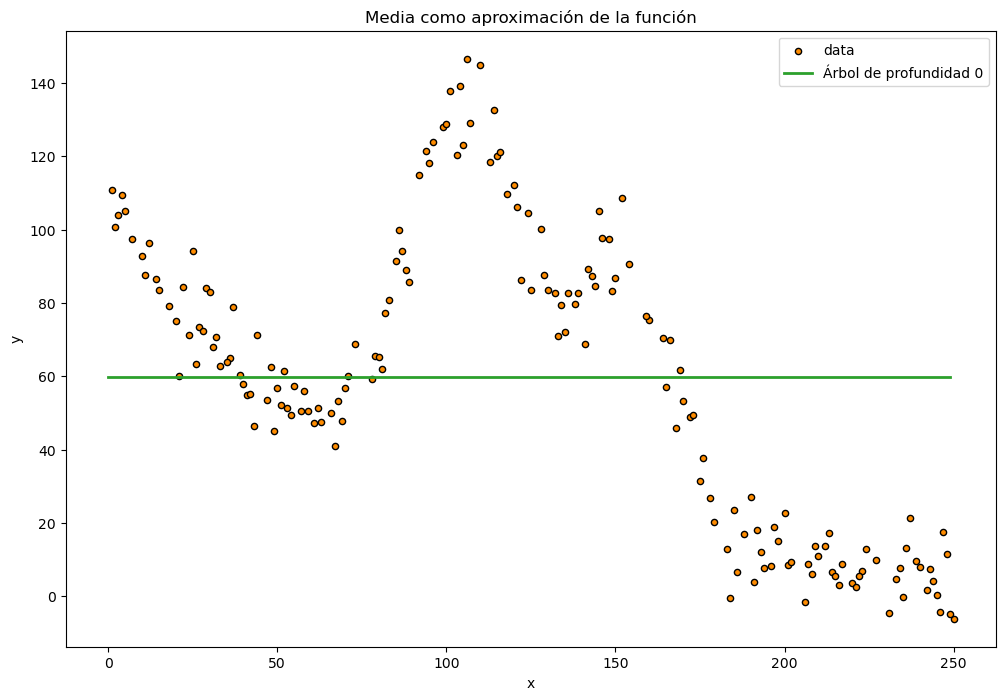

In [9]:
plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
mean = y.mean()
y_3 = np.ones_like(X_test)*mean
plt.plot(X_test, y_3, color="tab:green", label="Árbol de profundidad 0", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Media como aproximación de la función")
plt.legend()
plt.show()

Contrastand con lo anterior, no parar nunca de cortar un árbol termina por sobreajustarlo:

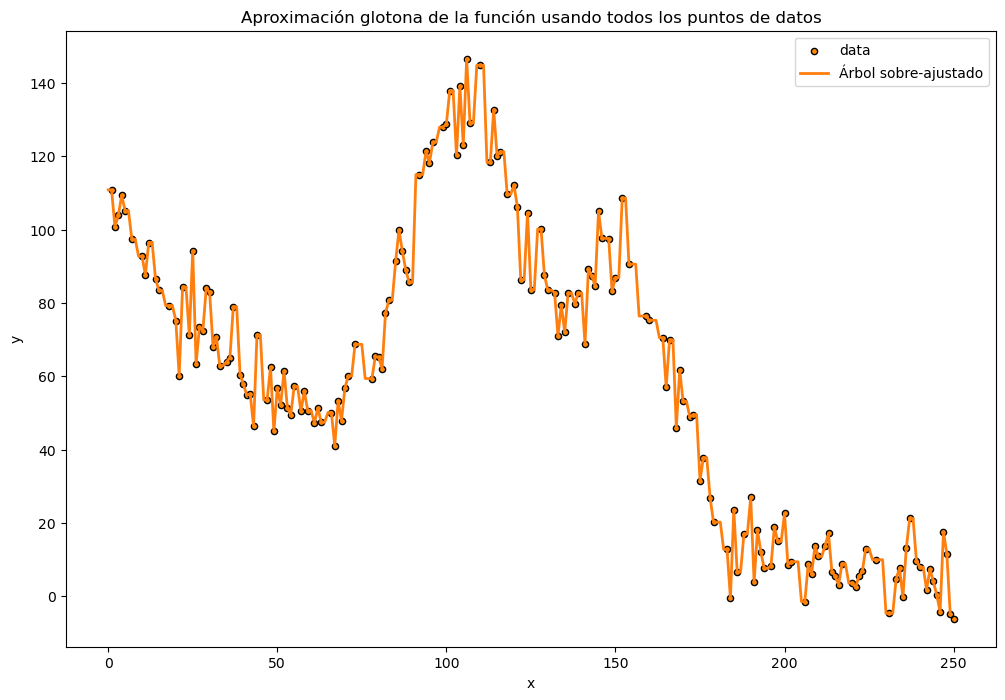

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_2, color="tab:orange", label="Árbol sobre-ajustado", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Aproximación glotona de la función usando todos los puntos de datos")
plt.legend()
plt.show()

Idealmente tendremos una profundidad que permita generalizar bien a distintas regiones del soporte de la función.

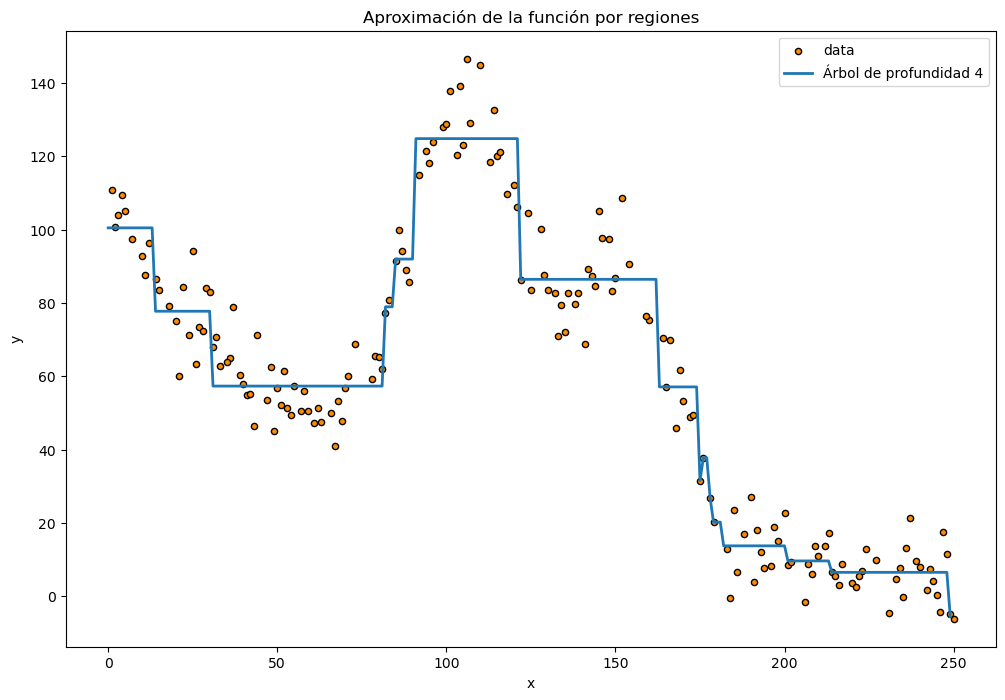

In [11]:
plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="tab:blue", label="Árbol de profundidad 4", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Aproximación de la función por regiones")
plt.legend()
plt.show()

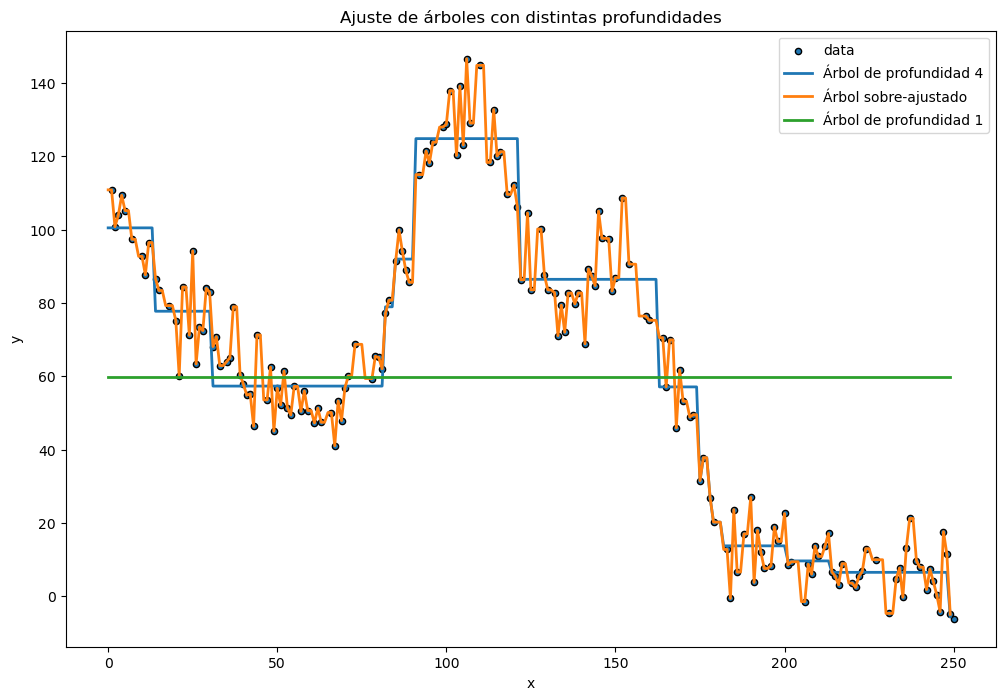

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, edgecolor="black", label="data")
plt.plot(X_test, y_1, label="Árbol de profundidad 4", linewidth=2)
plt.plot(X_test, y_2, label="Árbol sobre-ajustado", linewidth=2)
plt.plot(X_test, y_3, label="Árbol de profundidad 1", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Ajuste de árboles con distintas profundidades")
plt.legend()
plt.show()

## Bootstrapping y bagging

En palabras simples, bootstrapping es un procedimiento que
consiste en escoger aleatoriamente puntos de datos con
repetición, desde el conjunto de datos original. La repetición de
esto nos permite acceder a varias distribuciones que intentan
aproximar la original. 

In [13]:
import random

def bootstrapping_sample(X,y,size,seed=0):
    random.seed(seed)
    max_index = len(y)
    X_bootstrap, y_bootstrap = [], []
    for _ in range(size):
        i = random.randint(0, max_index-1)
        X_bootstrap.append(X[i])
        y_bootstrap.append(y[i])
    return np.array(X_bootstrap), np.array(y_bootstrap)

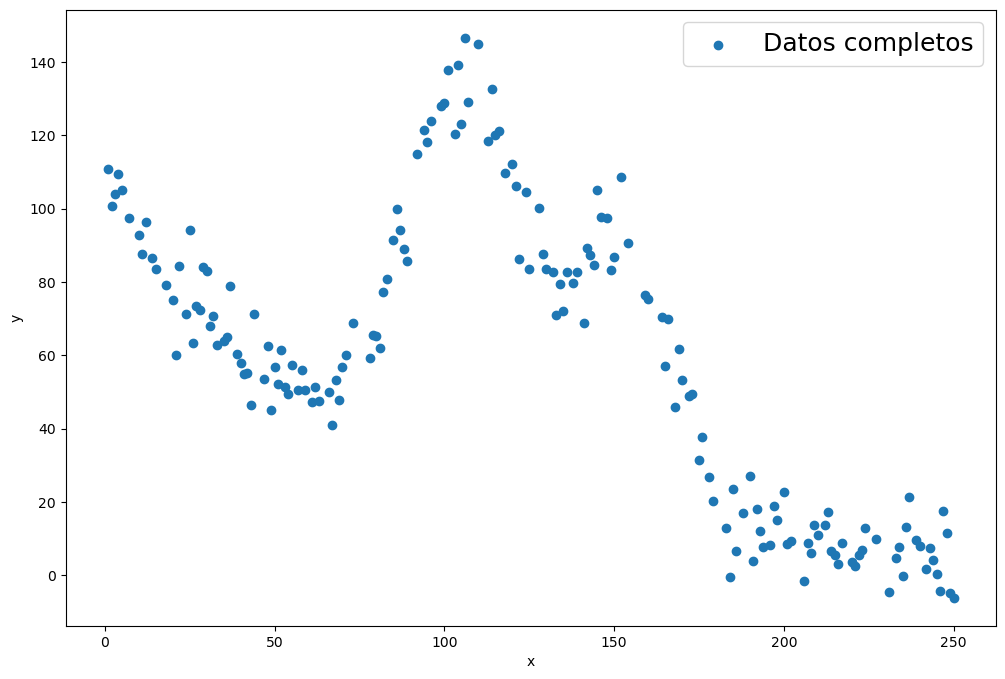

In [14]:
# plt.figure(figsize=(12,8))
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(X,y,label='Datos completos')
plt.legend(prop={'size': 18})
plt.xlabel('x')
plt.ylabel('y')
plt.plot();

In [15]:
sample_size = 50
X_bootstrap1, y_bootstrap1 = bootstrapping_sample(X,y,sample_size)

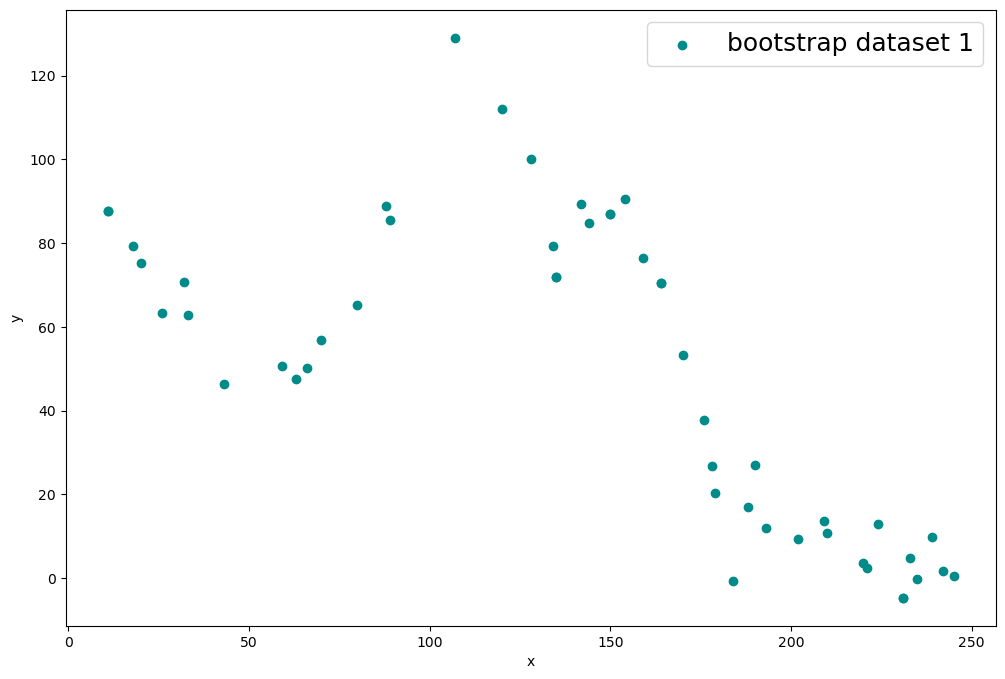

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(X_bootstrap1,y_bootstrap1,label='bootstrap dataset 1', c='darkcyan')
plt.legend(prop={'size': 18})
plt.xlabel('x')
plt.ylabel('y')
plt.plot();

In [17]:
X_bootstrap2, y_bootstrap2 = bootstrapping_sample(X,y,sample_size,seed=42)

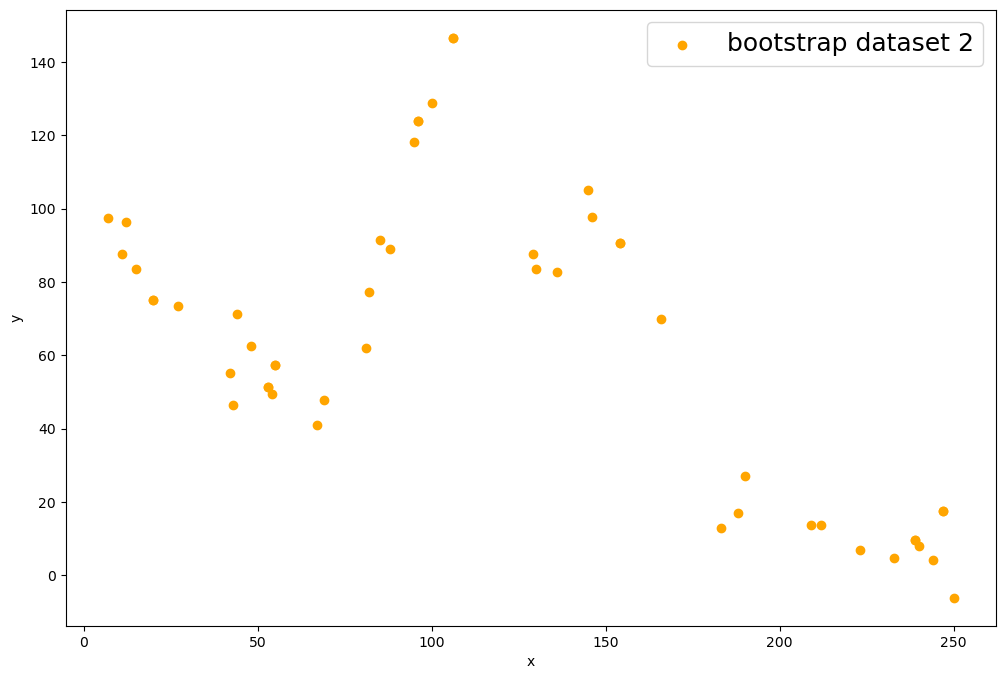

In [18]:
plt.figure(figsize=(12,8))
plt.scatter(X_bootstrap2,y_bootstrap2,label='bootstrap dataset 2',c='orange')
plt.legend(prop={'size': 18})
plt.xlabel('x')
plt.ylabel('y')
plt.plot();

El nombre **Bagging** proviene de la combinación de **b**ootstrap y
**agg**regagat**ing**, lo último correspondiendo a agregación de
modelos, lo cual viene de usar el promedio.

Ajuste de un árbol en el primer conjunto

In [19]:
tree_1 = DecisionTreeRegressor(max_depth=7)
tree_1.fit(X_bootstrap1.reshape(-1, 1), y_bootstrap1.reshape(-1, 1))

DecisionTreeRegressor(max_depth=7)

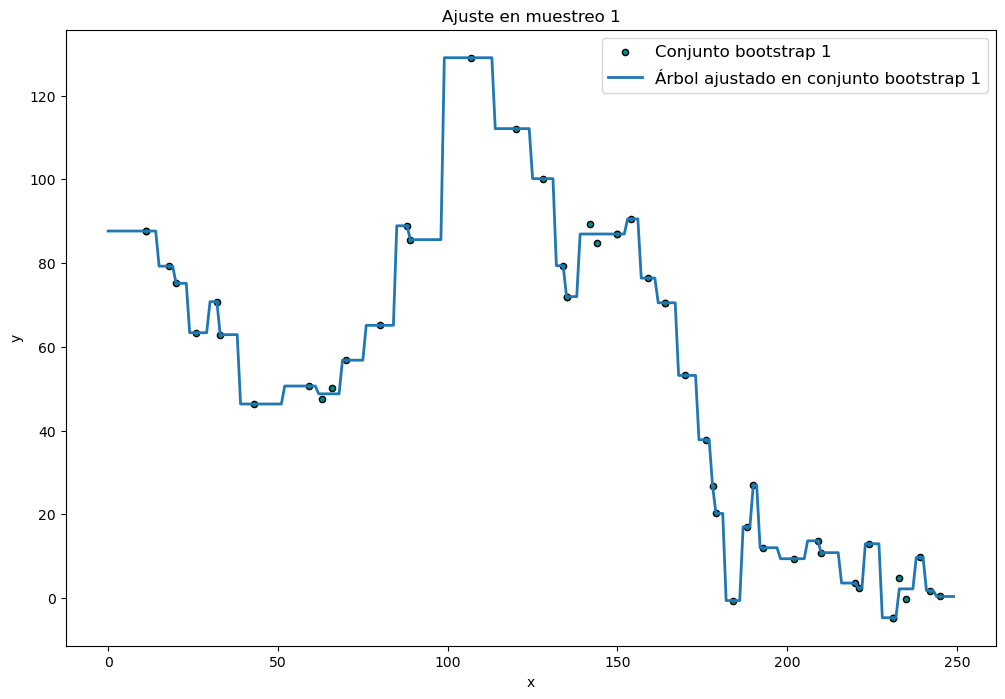

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(X_bootstrap1, y_bootstrap1, s=20, edgecolor="black", c="darkcyan", label="Conjunto bootstrap 1")
y_pred1 = tree_1.predict(X_test.reshape(-1, 1))
plt.plot(X_test, y_pred1, color="tab:blue", label="Árbol ajustado en conjunto bootstrap 1", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Ajuste en muestreo 1")
plt.legend(prop={'size': 12})
plt.show()

Ajuste de un árbol en el segundo conjunto

In [21]:
tree_2 = DecisionTreeRegressor(max_depth=7)
tree_2.fit(X_bootstrap2.reshape(-1, 1), y_bootstrap2.reshape(-1, 1))

DecisionTreeRegressor(max_depth=7)

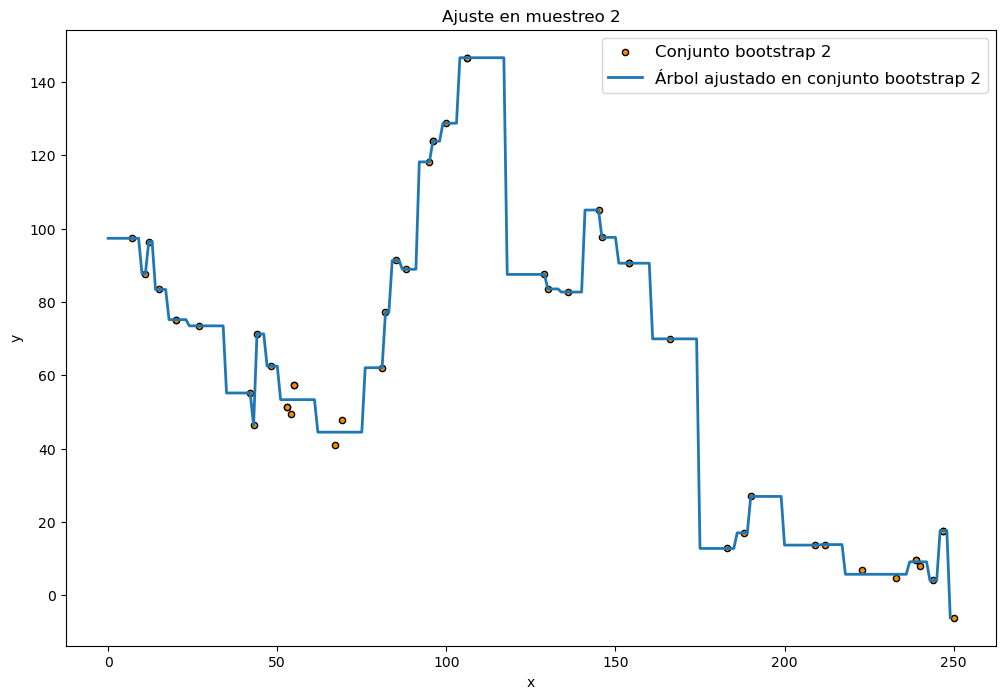

In [22]:
plt.figure(figsize=(12,8))
plt.scatter(X_bootstrap2, y_bootstrap2, s=20, edgecolor="black", c="darkorange", label="Conjunto bootstrap 2")
y_pred2 = tree_2.predict(X_test.reshape(-1, 1))
plt.plot(X_test, y_pred2, color="tab:blue", label="Árbol ajustado en conjunto bootstrap 2", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Ajuste en muestreo 2")
plt.legend(prop={'size': 12})
plt.show()

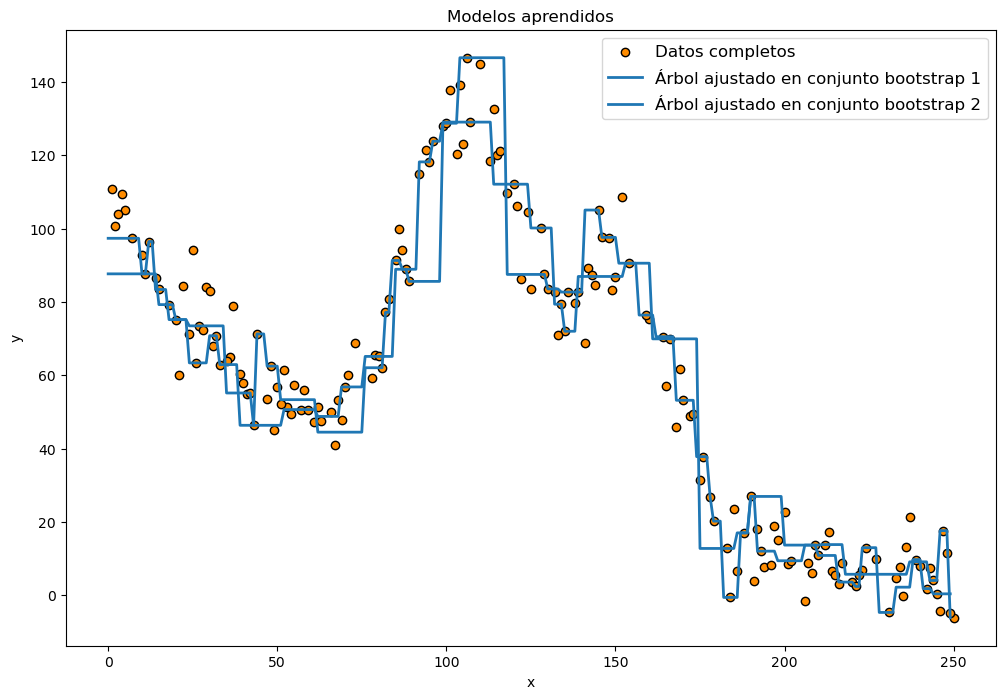

In [23]:
plt.scatter(X,y,edgecolor="black", c="darkorange", label="Datos completos")
plt.plot(X_test, y_pred1, color="tab:blue", label="Árbol ajustado en conjunto bootstrap 1", linewidth=2)
plt.plot(X_test, y_pred2, color="tab:blue", label="Árbol ajustado en conjunto bootstrap 2", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Modelos aprendidos")
plt.legend(prop={'size': 12})
plt.show()

El estimador _bagging_ corresponde a tomar el promedio de una sucesión de modelos.

In [24]:
bagging_pred = (y_pred1 + y_pred2) / 2

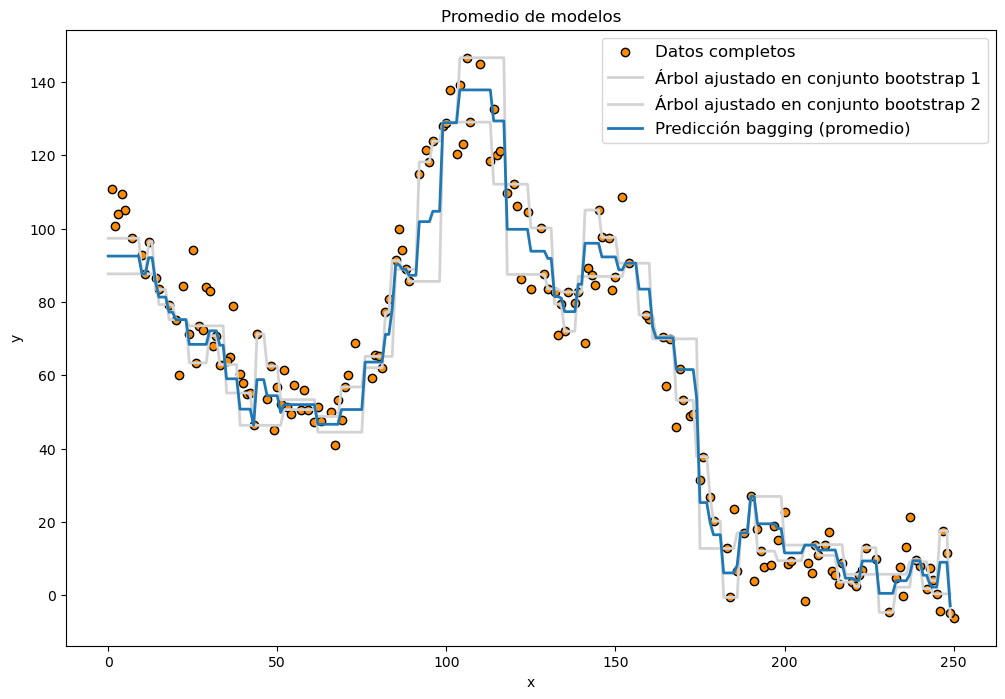

In [25]:
plt.scatter(X,y,edgecolor="black", c="darkorange", label="Datos completos")
plt.plot(X_test, y_pred1, color="lightgray", label="Árbol ajustado en conjunto bootstrap 1", linewidth=2)
plt.plot(X_test, y_pred2, color="lightgray", label="Árbol ajustado en conjunto bootstrap 2", linewidth=2)
plt.plot(X_test, bagging_pred, color="tab:blue", label="Predicción bagging (promedio)", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Promedio de modelos")
plt.legend(prop={'size': 12})
plt.show()